In [2]:
import os
print(os.getcwd())

c:\Users\AKHTAR HUSSAIN\Desktop\GIS & GEE\python_foundation\python_gis


In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
import geopandas as gpd
import requests
from io import StringIO

# Load data
url = "https://raw.githubusercontent.com/udit-001/india-maps-data/main/geojson/india.geojson"
response = requests.get(url)
gdf = gpd.read_file(StringIO(response.text))

# ✅ CORRECT: Call the method with (), not =
gdf.to_file("india.shp")                           # Shapefile
gdf.to_file("india.gpkg", driver="GPKG")          # GeoPackage

In [5]:
print(f"Current CRS:{gdf.crs}")

Current CRS:EPSG:4326


In [6]:
#reproject to wgs84 
gdf_4326 = gdf.to_crs(epsg =4326)
print(f"reprojected CRS :{gdf_4326.crs}")
gdf.head()

reprojected CRS :EPSG:4326


,id,district,dt_code,st_nm,st_code,year,geometry
0,None,Aizawl,261,Mizoram,15,2011_c,"POLYGON ((93.04466 23.41052, 92.9468 23.51363,..."
1,None,Champhai,262,Mizoram,15,2011_c,"MULTIPOLYGON (((93.04619 23.66623, 93.04466 23..."
2,None,Kolasib,263,Mizoram,15,2011_c,"POLYGON ((92.89633 24.39072, 92.86116 24.31374..."
3,None,Lawngtlai,264,Mizoram,15,2011_c,"POLYGON ((92.93456 22.55405, 92.9315 22.39458,..."
4,None,Lunglei,265,Mizoram,15,2011_c,"POLYGON ((92.67307 23.38303, 92.68989 23.32804..."


Spatial Measurements and Analysis

In [7]:
#Preparing Data for Accurate Measurements
gdf = gdf.to_crs("EPSG:3857")
#SET name as index for easier data access
gdf = gdf.set_index("st_nm")
print(f"now using crs:{gdf.crs}")

now using crs:EPSG:3857


Calculating Areas

In [8]:
#Calculate area in square meters
gdf["area"] = gdf.area

#convert to sqkm
gdf["area_km2"] = gdf["area"]/1000000

#Display results sorted by area
gdf[["area","area_km2",]].sort_values("area_km2",ascending=False)

,area,area_km2
st_nm,,
Rajasthan,4.302858e+11,430285.758789
Madhya Pradesh,3.683739e+11,368373.915745
Maharashtra,3.481167e+11,348116.731676
Uttar Pradesh,3.046216e+11,304621.580603
Ladakh,2.519403e+11,251940.279471
...,...,...
Dadra and Nagar Haveli and Daman and Diu,2.100127e+07,21.001268
Puducherry,1.519193e+07,15.191929
Lakshadweep,2.303429e+06,2.303429


Extracting Geometric Features

In [9]:
## Extract boundary lines from polygons
gdf["boundary"] = gdf.boundary
#calculate centroid 
gdf["centroid"] = gdf.centroid

# Display the geometric features
gdf[["boundary","centroid"]].head()

,boundary,centroid
st_nm,,
Mizoram,"LINESTRING (10357684.566 2681740.717, 10346789...",POINT (10340525.636 2731321.482)
Mizoram,"MULTILINESTRING ((10357854.794 2712789.071, 10...",POINT (10381896.026 2697199.642)
Mizoram,"LINESTRING (10341172.411 2801092.383, 10337257...",POINT (10322701.063 2777873.787)
Mizoram,"LINESTRING (10345428.121 2578177.191, 10345087...",POINT (10320831.193 2558110.116)
Mizoram,"LINESTRING (10316319.063 2678405.768, 10318191...",POINT (10314152.383 2629414.498)


Distance Calculations

In [10]:
# Dissolve to state level
gdf_states = gdf.dissolve(by="st_nm", as_index=False)

# Create centroids
gdf_states["centroid"] = gdf_states.geometry.centroid

# Get Delhi centroid
delhi_centroid = gdf_states.loc[gdf_states['st_nm'] == "Delhi", "centroid"].iloc[0]

# Calculate distances (FIXED: single line)
gdf_states["distance_to_delhi"] = gdf_states["centroid"].distance(delhi_centroid)

# Convert to km
gdf_states["distance_to_delhi_km"] = gdf_states["distance_to_delhi"] / 1000

# Sort and display
result = gdf_states[["st_nm", "distance_to_delhi_km"]].sort_values("distance_to_delhi_km")
print(result)

                                       st_nm  distance_to_delhi_km
8                                      Delhi              0.000000
11                                   Haryana            111.478790
5                                 Chandigarh            269.066792
34                               Uttarakhand            303.371058
27                                    Punjab            339.960911
12                          Himachal Pradesh            424.142959
33                             Uttar Pradesh            438.450110
28                                 Rajasthan            444.205387
19                            Madhya Pradesh            644.494559
13                         Jammu and Kashmir            698.478834
17                                    Ladakh            829.501184
10                                   Gujarat            958.364983
4                                      Bihar           1015.470993
6                               Chhattisgarh           1057.54

Statistical Analysis of Spatial Data

In [11]:
# 5. Statistics (use gdf_states!)
mean_distance = gdf_states["distance_to_delhi_km"].mean()
max_distance = gdf_states["distance_to_delhi_km"].max()
total_area = gdf_states["area_km2"].sum()

print(f"Mean distance: {mean_distance:.2f} km")
print(f"Max distance: {max_distance:.2f} km")
print(f"Total area: {total_area:,.2f} km²")

Mean distance: 1260.14 km
Max distance: 2712.37 km
Total area: 394,590.94 km²


Visualizing Geospatial Data

In [12]:
# Set high resolution for better quality plots
plt.rcParams["figure.dpi"] = 150

 Thematic Mapping

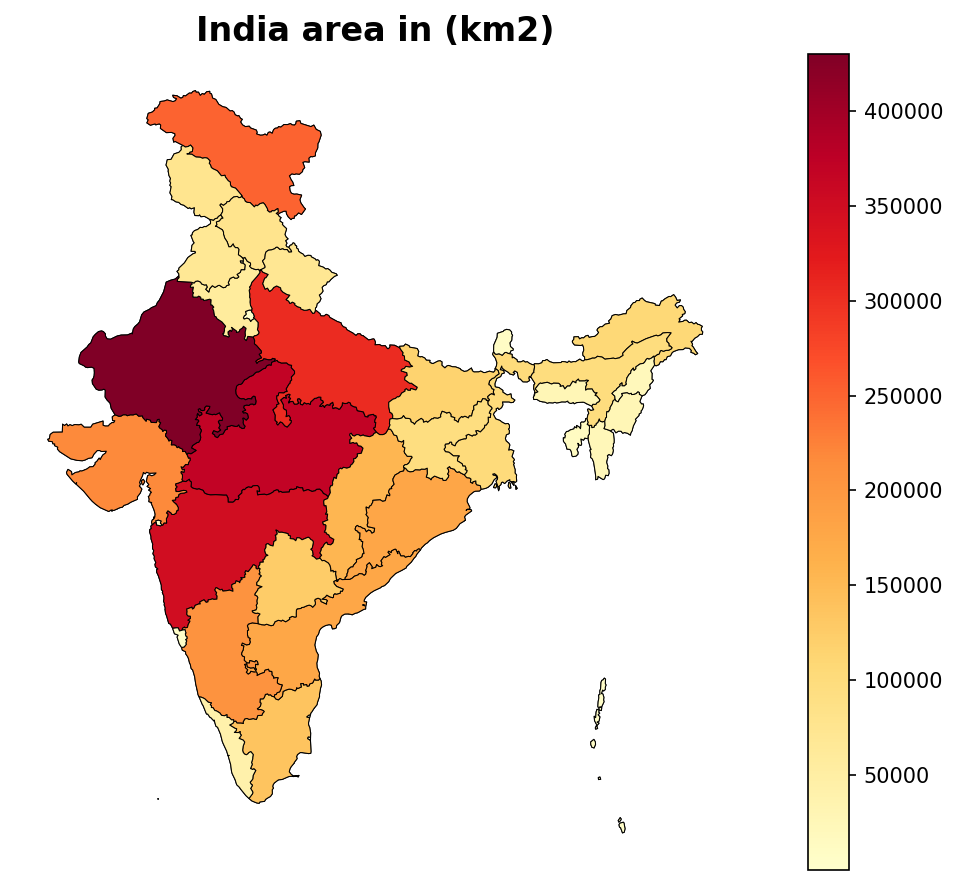

In [13]:
#Create a choropleth map showing borough areas
fig,ax = plt.subplots(figsize=(10,6))

gdf.plot(
    column="area_km2",
    ax =ax,
    legend=True,
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.5,
)

plt.title("India area in (km2)", fontsize =16,fontweight ="bold")
plt.axis("off")
plt.tight_layout()
plt.savefig("India area in km2")
plt.show()

Multi-Layer Visualization

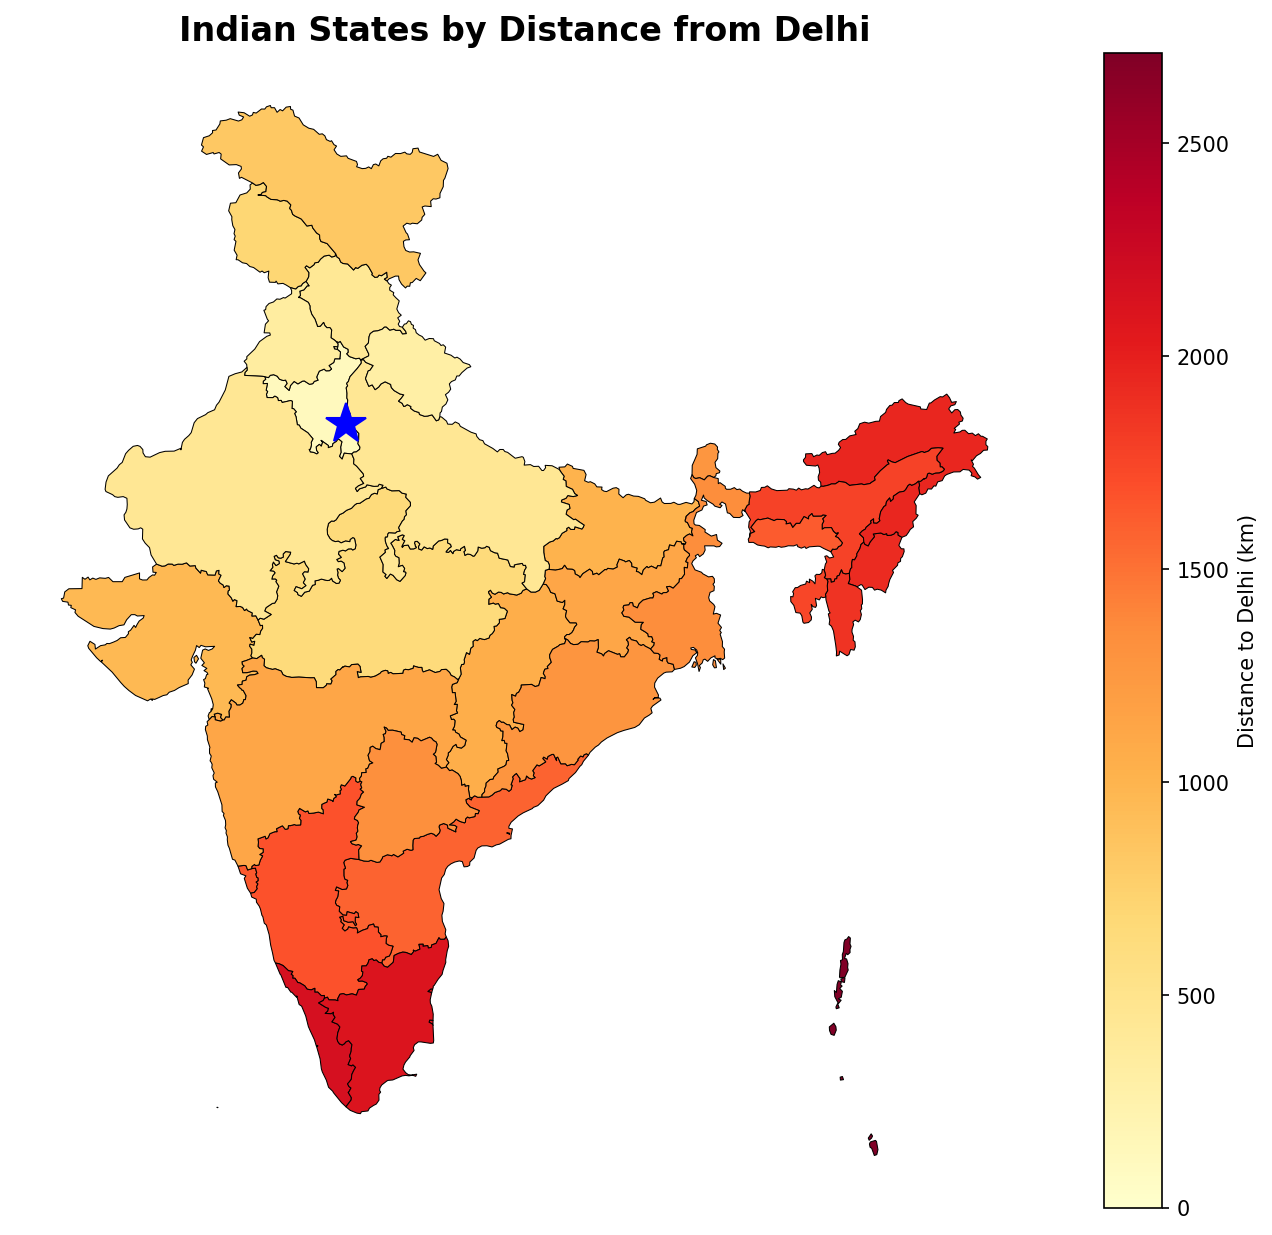

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))

# Color by distance to Delhi
gdf_states.plot(
    column='distance_to_delhi_km',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Distance to Delhi (km)'},
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# Add Delhi star
delhi_row = gdf_states[gdf_states['st_nm'] == 'Delhi'].iloc[0]
ax.plot(delhi_row.centroid.x, delhi_row.centroid.y, 'b*', markersize=20, label='Delhi')

plt.title("Indian States by Distance from Delhi", fontsize=16, fontweight='bold')
plt.axis('off')
plt.savefig("india_distance_map.png", dpi=300, bbox_inches='tight')
plt.show()

Interactive Visualization

In [18]:
m = gdf.explore(
    column="area_km2",
    cmap="YlOrRd",
    tooltip=["area_km2", "st_nm"],
    popup=True,
    legend=True,
)
m

Advanced Geometric Operations

In [19]:
#Buffer Analysis
#Create 3-kilometer buffer zones around each borough
buffer_distance = 3000  # meters
gdf["buffered"] = gdf.buffer(buffer_distance)

print(f"Created {buffer_distance/1000} km buffer zones around each state")

Created 3.0 km buffer zones around each state


C:\Users\AKHTAR HUSSAIN\AppData\Local\Temp\ipykernel_3628\2637024977.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")
C:\Users\AKHTAR HUSSAIN\AppData\Local\Temp\ipykernel_3628\2637024977.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


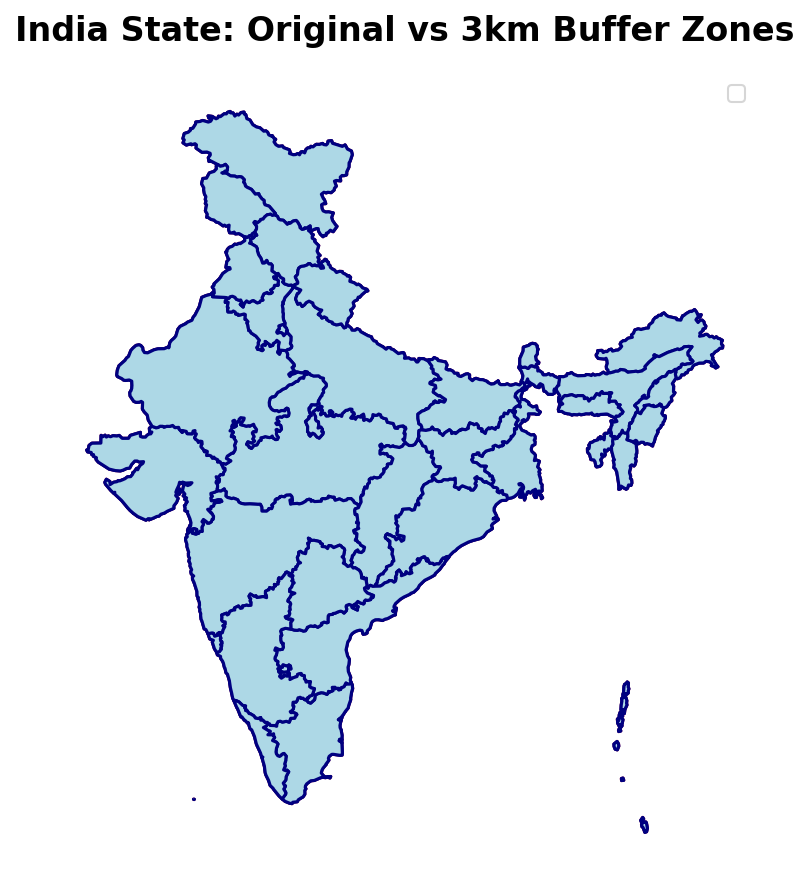

In [23]:
# Visualize original vs buffered geometries
fig, ax = plt.subplots(figsize=(10, 6))

# Plot buffered areas first (background)
gdf["buffered"].plot(
    ax=ax,
    alpha=0.3,
    color="orange",
    edgecolor="red",
    linewidth=1,
    label="3km Buffer Zone",
)

# Plot original geometries on top
gdf["geometry"].plot(
    ax=ax,
    color="lightblue",
    edgecolor="navy",
    linewidth=1.5,
    label="Original Boundaries",
)

plt.title("India State: Original vs 3km Buffer Zones", fontsize=16, fontweight="bold")
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.savefig("india_statebuffer_map.png", dpi=300, bbox_inches='tight')
plt.show()

Convex Hull Analysis

In [24]:
# Calculate convex hulls for each borough
gdf["convex_hull"] = gdf.convex_hull

# Compare areas between original shapes and convex hulls
gdf["convex_hull_area"] = gdf["convex_hull"].area / 1_000_000  # Convert to km²
gdf["area_ratio"] = gdf["convex_hull_area"] / gdf["area_km2"]

print("Convex Hull Analysis:")
print(gdf[["area_km2", "convex_hull_area", "area_ratio"]].round(2))

Convex Hull Analysis:
                   area_km2  convex_hull_area  area_ratio
st_nm                                                    
Mizoram             4373.31           6037.65        1.38
Mizoram             2614.83           4237.94        1.62
Mizoram             1630.06           1882.42        1.15
Mizoram             2277.33           2956.60        1.30
Mizoram             4268.14           4827.46        1.13
...                     ...               ...         ...
Jammu and Kashmir  77105.31          87574.99        1.14
Himachal Pradesh   77760.33          95310.66        1.23
Punjab             68374.35          85478.69        1.25
Uttarakhand        71514.05          85080.05        1.19
Chandigarh           109.63            109.63        1.00

[759 rows x 3 columns]


C:\Users\AKHTAR HUSSAIN\AppData\Local\Temp\ipykernel_3628\1119879491.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right")
C:\Users\AKHTAR HUSSAIN\AppData\Local\Temp\ipykernel_3628\1119879491.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


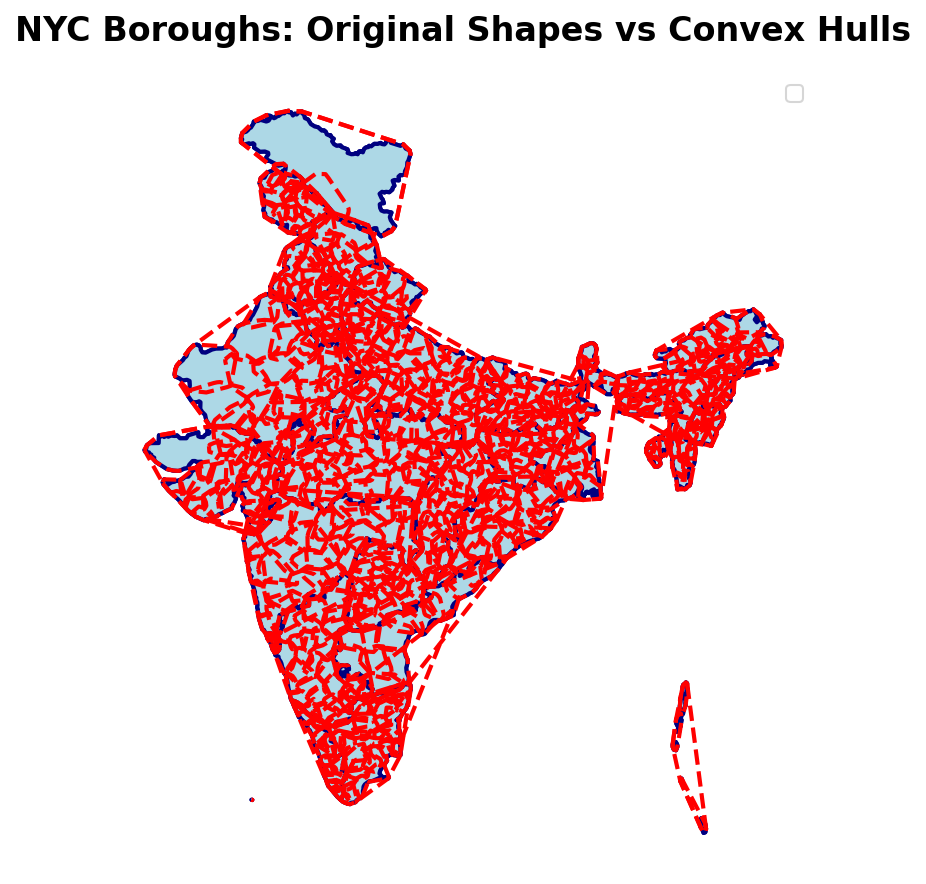

In [26]:
# Create comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original geometries
gdf["geometry"].plot(
    ax=ax, color="lightblue", edgecolor="navy", linewidth=2, label="Original Shape"
)

# Plot convex hulls as outlines
gdf["convex_hull"].plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    linestyle="--",
    label="Convex Hull",
)

plt.title(
    "NYC Boroughs: Original Shapes vs Convex Hulls", fontsize=16, fontweight="bold"
)
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.savefig("india_convex_hull_map.png", dpi=300, bbox_inches='tight')
plt.show()

Spatial Relationships and Queries

In [28]:
# Use state-level data for cleaner results
gdf_states = gdf.dissolve(by="st_nm", as_index=False)
gdf_states = gdf_states.to_crs("EPSG:7755")

# Create buffer (e.g., 100km)
gdf_states["buffered"] = gdf_states.geometry.buffer(100000)

# Get Delhi
delhi_geom = gdf_states.loc[gdf_states["st_nm"] == "Delhi", "geometry"].iloc[0]

# Test spatial relationships
gdf_states["intersects_delhi"] = gdf_states["buffered"].intersects(delhi_geom)
gdf_states["touches_delhi"] = gdf_states["buffered"].touches(delhi_geom)

# Show only True results
neighbors = gdf_states[gdf_states["intersects_delhi"]][["st_nm", "intersects_delhi", "touches_delhi"]]
print(neighbors)

            st_nm  intersects_delhi  touches_delhi
8           Delhi              True          False
11        Haryana              True          False
28      Rajasthan              True          False
33  Uttar Pradesh              True          False


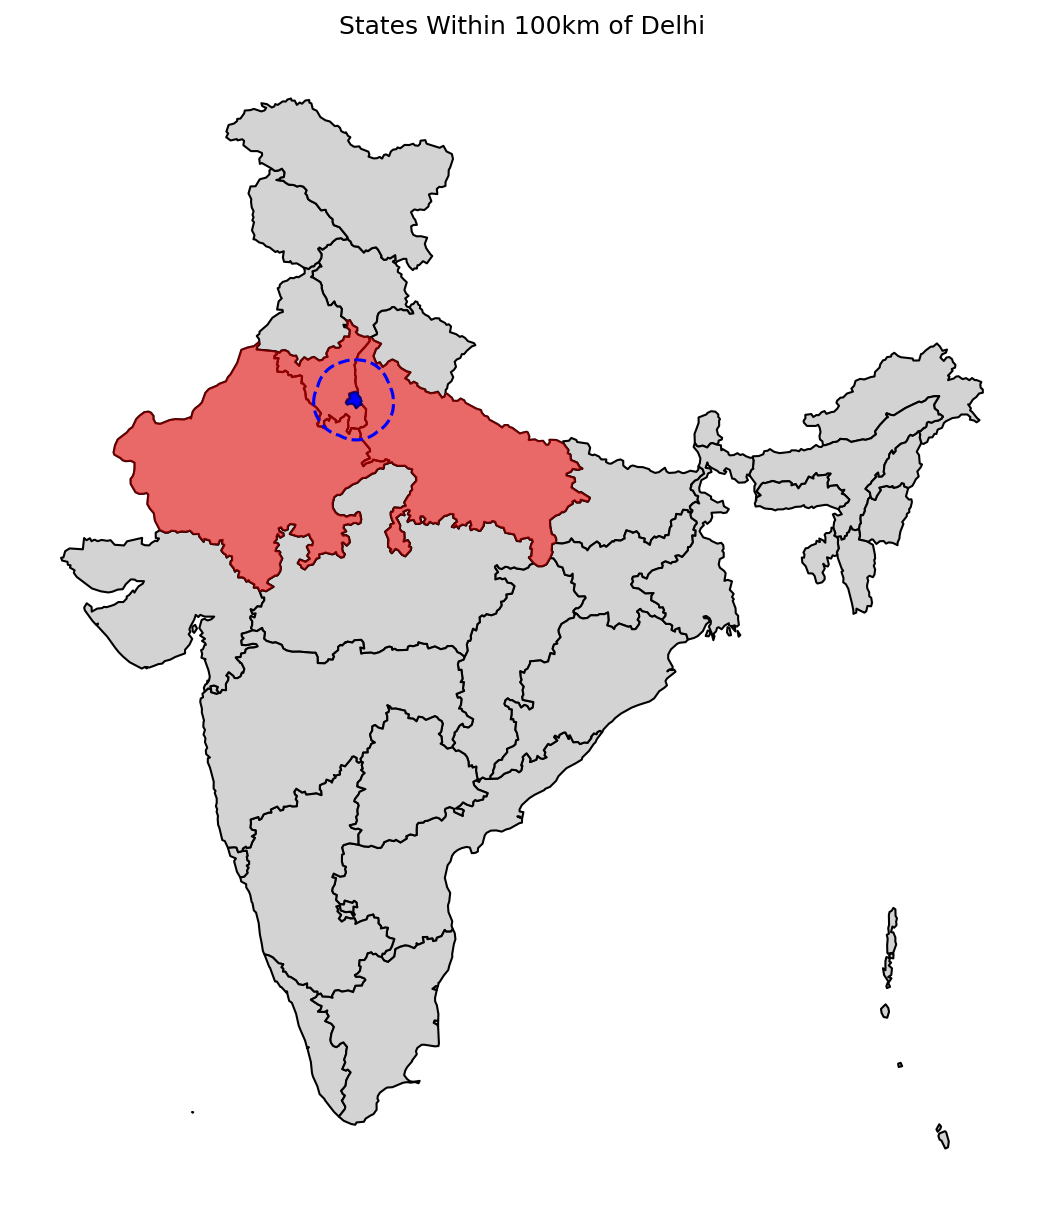

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all states
gdf_states.plot(ax=ax, color="lightgray", edgecolor="black")

# Highlight states that intersect with Delhi's buffer
intersecting = gdf_states[gdf_states["intersects_delhi"]]
intersecting.plot(ax=ax, color="red", alpha=0.5, edgecolor="darkred")

# Plot Delhi
delhi = gdf_states[gdf_states["st_nm"] == "Delhi"]
delhi.plot(ax=ax, color="blue", edgecolor="navy")

# Plot buffer boundary
delhi_buffer = gdf_states[gdf_states["st_nm"] == "Delhi"]["buffered"].iloc[0]
gpd.GeoSeries([delhi_buffer]).boundary.plot(ax=ax, color="blue", linestyle="--")

plt.title("States Within 100km of Delhi")
plt.axis("off")
plt.savefig("States within_100km_map.png", dpi=300, bbox_inches='tight')
plt.show()

Nearest Neighbor Analysis
Find the closest state to each state

In [32]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Get centroids
centroids = np.array([(geom.x, geom.y) for geom in gdf_states["centroid"]])

# Calculate distance matrix
dist_matrix = squareform(pdist(centroids))

# Find nearest neighbor (excluding self)
np.fill_diagonal(dist_matrix, np.inf)
nearest_idx = dist_matrix.argmin(axis=1)
gdf_states["nearest_state"] = gdf_states.iloc[nearest_idx]["st_nm"].values
gdf_states["nearest_distance_km"] = dist_matrix.min(axis=1) / 1000

<Axes: >

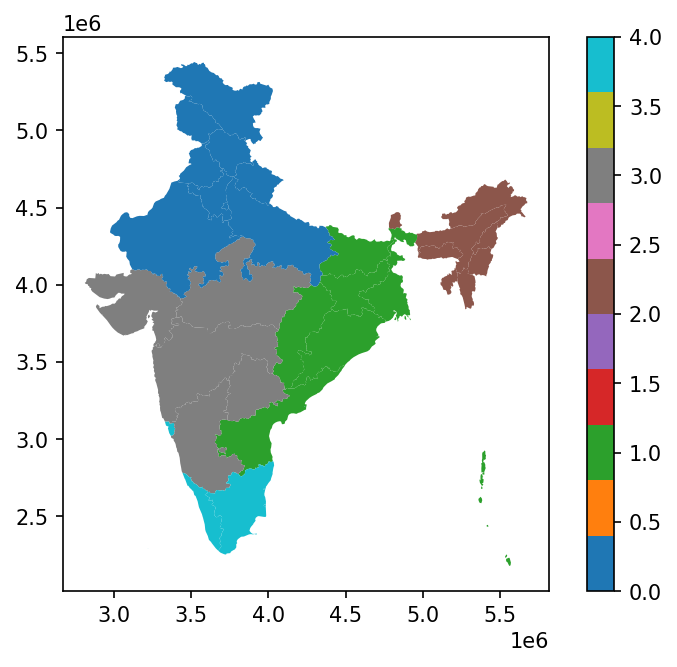

In [33]:
# Cluster Analysis (Regional Grouping)
#Group states by geographic proximity
from sklearn.cluster import KMeans

# Cluster states into regions
coords = np.array([(geom.x, geom.y) for geom in gdf_states["centroid"]])
kmeans = KMeans(n_clusters=5, random_state=42)
gdf_states["region_cluster"] = kmeans.fit_predict(coords)

# Visualize
gdf_states.plot(column="region_cluster", cmap="tab10", legend=True)

Voronoi Diagrams
Divide space into nearest-state regions

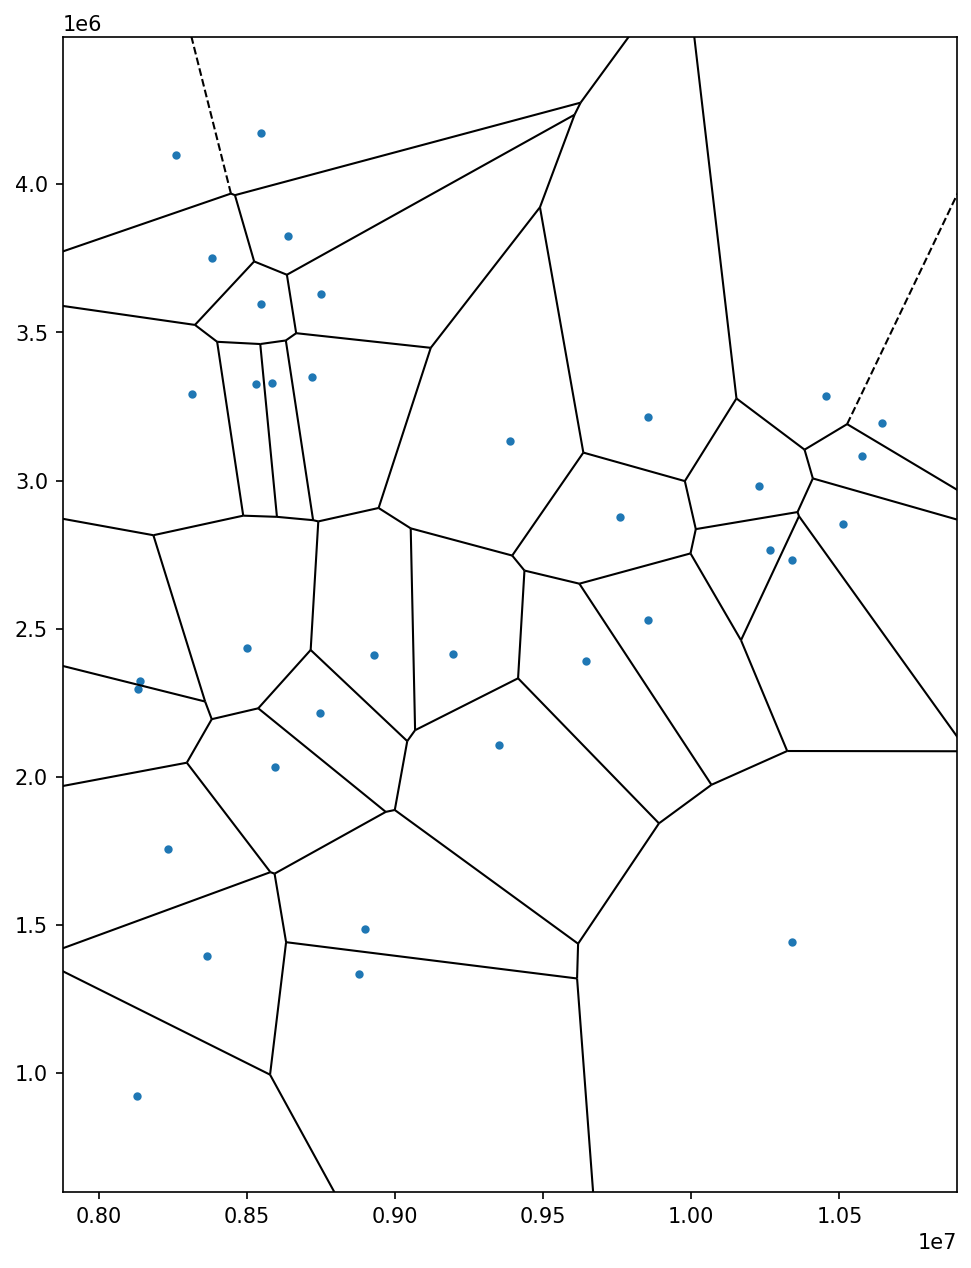

In [36]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

coords = np.array([(geom.x, geom.y) for geom in gdf_states["centroid"]])
vor = Voronoi(coords)

fig, ax = plt.subplots(figsize=(10, 10))
voronoi_plot_2d(vor, ax=ax, show_vertices=False)
gdf_states.boundary.plot(ax=ax, color="red")
plt.show()

Network Analysis: Shortest Path
Find shortest route through multiple states

In [40]:
import networkx as nx
from shapely.ops import nearest_points

# Create graph of state centroids
G = nx.Graph()
for i, row in gdf_states.iterrows():
    for j, row2 in gdf_states.iterrows():
        if i < j:
            dist = row["centroid"].distance(row2["centroid"])
            G.add_edge(row["st_nm"], row2["st_nm"], weight=dist)

# Shortest path from Delhi to Tamil Nadu
path = nx.shortest_path(G, "Delhi", "Tamil Nadu", weight="weight")
print(" → ".join(path))

Delhi → Tamil Nadu


Density Analysis (Kernel Density Estimation)
Find hotspots of state centroids

<Axes: >

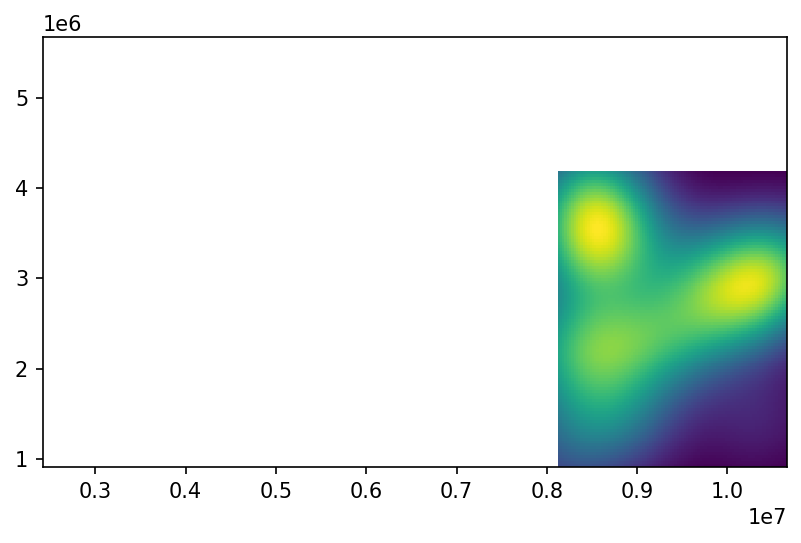

In [41]:
from scipy.stats import gaussian_kde

x = [geom.x for geom in gdf_states["centroid"]]
y = [geom.y for geom in gdf_states["centroid"]]
k = gaussian_kde(np.vstack([x, y]))

# Create grid
xi, yi = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
gdf_states.boundary.plot(ax=plt.gca(), color="white", alpha=0.5)

Overlay Analysis
Find overlapping areas between buffers

In [42]:
# Create 200km buffers
gdf_states["buffer_200km"] = gdf_states.geometry.buffer(200000)

# Find intersection between Delhi and Haryana buffers
delhi_buffer = gdf_states.loc[gdf_states["st_nm"] == "Delhi", "buffer_200km"].iloc[0]
haryana_buffer = gdf_states.loc[gdf_states["st_nm"] == "Haryana", "buffer_200km"].iloc[0]

intersection_area = delhi_buffer.intersection(haryana_buffer).area / 1_000_000
print(f"Overlap area: {intersection_area:.2f} km²")

Overlap area: 157549.15 km²


In [46]:
import pandas as pd

# Raw URL (correct format)
url = "https://raw.githubusercontent.com/nishusharma1608/India-Census-2011-Analysis/master/india-districts-census-2011.csv"

# Read directly into pandas
df_pop = pd.read_csv(url)

print(f"✅ Loaded {len(df_pop)} rows")
print(f"Columns: {df_pop.columns.tolist()}")
print("\nFirst 5 rows:")
print(df_pop.head())

✅ Loaded 640 rows
Columns: ['District code', 'State name', 'District name', 'Population', 'Male', 'Female', 'Literate', 'Male_Literate', 'Female_Literate', 'SC', 'Male_SC', 'Female_SC', 'ST', 'Male_ST', 'Female_ST', 'Workers', 'Male_Workers', 'Female_Workers', 'Main_Workers', 'Marginal_Workers', 'Non_Workers', 'Cultivator_Workers', 'Agricultural_Workers', 'Household_Workers', 'Other_Workers', 'Hindus', 'Muslims', 'Christians', 'Sikhs', 'Buddhists', 'Jains', 'Others_Religions', 'Religion_Not_Stated', 'LPG_or_PNG_Households', 'Housholds_with_Electric_Lighting', 'Households_with_Internet', 'Households_with_Computer', 'Rural_Households', 'Urban_Households', 'Households', 'Below_Primary_Education', 'Primary_Education', 'Middle_Education', 'Secondary_Education', 'Higher_Education', 'Graduate_Education', 'Other_Education', 'Literate_Education', 'Illiterate_Education', 'Total_Education', 'Age_Group_0_29', 'Age_Group_30_49', 'Age_Group_50', 'Age not stated', 'Households_with_Bicycle', 'Househol

In [48]:
def merge_population_with_geo(gdf, df_pop):
    # Create copies to avoid modifying originals
    gdf = gdf.copy()
    df_pop = df_pop.copy()
    
    # Find state column (flexible matching)
    state_col_gdf = None
    for col in gdf.columns:
        if 'state' in col.lower() or 'st_' in col.lower():
            state_col_gdf = col
            break
    
    if state_col_gdf is None:
        raise KeyError("No state column found in GeoDataFrame. Columns: " + str(gdf.columns.tolist()))
    
    # Find district column
    dist_col_gdf = None
    for col in gdf.columns:
        if 'district' in col.lower() or 'dt_' in col.lower():
            dist_col_gdf = col
            break
    
    print(f"Using state column: {state_col_gdf}")
    print(f"Using district column: {dist_col_gdf}")
    
    # Standardize
    gdf['State'] = gdf[state_col_gdf].astype(str).str.strip().str.upper()
    gdf['District'] = gdf[dist_col_gdf].astype(str).str.strip().str.upper()
    
    df_pop['State'] = df_pop['State name'].astype(str).str.strip().str.upper()
    df_pop['District'] = df_pop['District name'].astype(str).str.strip().str.upper()
    
    # Merge
    merged = gdf.merge(df_pop, on=['State', 'District'], how='left')
    
    print(f"Merged: {len(merged)} rows")
    print(f"With population data: {merged['Population'].notna().sum()}")
    
    return merged

# Use it
gdf_merged = merge_population_with_geo(gdf, df_pop)

Using state column: st_code
Using district column: district
Merged: 759 rows
With population data: 0
